**PREPARING YOLOV5 TYPE LABELS FOR THEIR RESPECTIVE IMAGES USING PREDIFINED LABELS**

In [ ]:
import os
import pandas as pd
import shutil

base_dir = '/content/drive/MyDrive'
train_images_dir = os.path.join(base_dir, 'images/train')
train_labels_dir = os.path.join(base_dir, 'labels/train')
val_images_dir = os.path.join(base_dir, 'images/val')
val_labels_dir = os.path.join(base_dir, 'labels/val')

# Create directories if they don't exist
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)

# Load the CSV data
csv_path = '/content/drive/MyDrive/Train.csv'
data = pd.read_csv(csv_path)

def copy_images_and_create_labels(data_subset, images_dir, labels_dir, folder_type, image_base_path):
    for index, row in data_subset.iterrows():
        image_path = row['Path']
        class_id = row['ClassId']
        image_filename = os.path.basename(image_path)
        # print(image_filename)
        folder_name = os.path.dirname(image_path).split('/')[-1]
        full_image_path = os.path.join(image_base_path, folder_name, image_filename)

        if os.path.exists(full_image_path):
            shutil.copy(full_image_path, images_dir)

            # Prepare YOLO format for the label file
            x_center = (row['Roi.X1'] + row['Roi.X2']) / 2 / row['Width']
            y_center = (row['Roi.Y1'] + row['Roi.Y2']) / 2 / row['Height']
            width = (row['Roi.X2'] - row['Roi.X1']) / row['Width']
            height = (row['Roi.Y2'] - row['Roi.Y1']) / row['Height']

            label_file_name = os.path.splitext(image_filename)[0] + '.txt'
            label_path = os.path.join(labels_dir, label_file_name)

            # Write to label file in YOLO format
            with open(label_path, 'a') as label_file:
                label_file.write(f"{int(class_id)} {x_center} {y_center} {width} {height}\n")
            print(f"Processed ({folder_type}): {image_filename}")
        else:
            print(f"Image not found: {full_image_path}")

# Copy images and create label files for training and validation sets
copy_images_and_create_labels(data[data['Path'].str.contains('Train')], train_images_dir, train_labels_dir, 'Train', '/content/drive/MyDrive/VIDEO_BASED_TRAFFIC_SIGNS/TRAIN_FOLDERS')
copy_images_and_create_labels(data[data['Path'].str.contains('Train')], val_images_dir, val_labels_dir, 'validation', '/content/drive/MyDrive/VIDEO_BASED_TRAFFIC_SIGNS/VALIDATION_FOLDERS')


# /content/drive/MyDrive/VIDEO_BASED_TRAFFIC_SIGNS/TRAIN_FOLDERS/1/00001_00000_00000.png

Streaming output truncated to the last 5000 lines.
Image not found: /content/drive/MyDrive/VIDEO_BASED_TRAFFIC_SIGNS/VALIDATION_FOLDERS/35/00035_00000_00010.png
Image not found: /content/drive/MyDrive/VIDEO_BASED_TRAFFIC_SIGNS/VALIDATION_FOLDERS/35/00035_00000_00011.png
Image not found: /content/drive/MyDrive/VIDEO_BASED_TRAFFIC_SIGNS/VALIDATION_FOLDERS/35/00035_00000_00012.png
Image not found: /content/drive/MyDrive/VIDEO_BASED_TRAFFIC_SIGNS/VALIDATION_FOLDERS/35/00035_00000_00013.png
Image not found: /content/drive/MyDrive/VIDEO_BASED_TRAFFIC_SIGNS/VALIDATION_FOLDERS/35/00035_00000_00014.png
Image not found: /content/drive/MyDrive/VIDEO_BASED_TRAFFIC_SIGNS/VALIDATION_FOLDERS/35/00035_00000_00015.png
Image not found: /content/drive/MyDrive/VIDEO_BASED_TRAFFIC_SIGNS/VALIDATION_FOLDERS/35/00035_00000_00016.png
Image not found: /content/drive/MyDrive/VIDEO_BASED_TRAFFIC_SIGNS/VALIDATION_FOLDERS/35/00035_00000_00017.png
Image not found: /content/drive/MyDrive/VIDEO_BASED_TRAFFIC_SIGNS/VAL

**CHANGING THE LABELS OF IMAGES TO COMPRESS THEM FROM 22 CLASSES TO 06 CLASSES FOR ACCURACY IN VIDEO**


In [ ]:
import os

class_mapping = {
    # 19: 16,  # Dangerous curve left
    # 20: 17,  # Dangerous curve right
    # 27: 18,  # Pedestrians
    # 33: 19,  # Turn right ahead
    # 34: 20,  # Turn left ahead
    # 38: 21,  # Keep right
    # 39: 22   # Keep left

    # 1:0, #30 speed
    # 3:2, #60 speed
    # 27:3, #pedestrain crossing
    # 34:4, #turn left ahead
    # 33:5, #turn right ahead
    # 38:6, #keep right

    1:0, #30 speed
    2:1, #60 speed
    3:2, #pedestrain crossing
    4:3, #turn left ahead
    5:4, #turn right ahead
    6:5, #keep right
}

annotations_dir = ['/content/drive/MyDrive/labels/train','/content/drive/MyDrive/labels/val']


# Function to update annotations
def update_annotations(directory):
    global count
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):  # Assuming annotations are in .txt format
            file_path = os.path.join(directory, filename)
            updated_lines = []
            with open(file_path, 'r') as file:
                for line in file:
                    parts = line.strip().split()  # Split the line into components
                    if len(parts) > 0:
                        original_class_id = int(parts[0])
                        new_class_id = class_mapping.get(original_class_id, original_class_id)
                        # Create the updated line with the new class ID
                        updated_line = f"{new_class_id} {' '.join(parts[1:])}"
                        updated_lines.append(updated_line)

            with open(file_path, 'w') as file:
                for updated_line in updated_lines:
                    file.write(updated_line + '\n')
                    count += 1


for ann in annotations_dir:
  count = 0
  update_annotations(ann)

print("Annotation files updated successfully.")
print(count)

Annotation files updated successfully.
194


**Importing YOLOv5 Model for Training from Scratch (Without Pre-trained Weights)**

In [ ]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5

!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17026, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 17026 (delta 1), reused 0 (delta 0), pack-reused 17022 (from 1)
Receiving objects: 100% (17026/17026), 15.63 MiB | 17.40 MiB/s, done.
Resolving deltas: 100% (11696/11696), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.2/881.2 kB 22.3 MB/s eta 0:00:00


**Creating a Custom YAML File for YOLOv5 Training**

In [ ]:
yaml_file_path = '/content/yolov5/data/custom_data.yaml'

yaml_content = """
train: /content/drive/MyDrive/images/train  # path to training images
val: /content/drive/MyDrive/images/val      # path to validation images

nc: 6  # number of classes
names: [
    '30 speed',
    '60 speed',
    'pedestrain crossing',
    'turn left ahead',
    'turn right ahead',
    'keep right'
]
"""

with open(yaml_file_path, 'w') as f:
    f.write(yaml_content.strip())

print(f"YAML file created at {yaml_file_path}.")


YAML file created at /content/yolov5/data/custom_data.yaml.


**TRAINING THE MODEL**

In [ ]:
!python /content/yolov5/train.py --img 640 --batch 16 --epochs 60 --data /content/yolov5/data/custom_data.yaml


Streaming output truncated to the last 5000 lines.
  with torch.cuda.amp.autocast(amp):
       2/59      5.08G    0.05171    0.01872    0.03537         42        640:  76% 31/41 [00:13<00:05,  1.82it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
       2/59      5.08G    0.05201    0.01878    0.03526         45        640:  78% 32/41 [00:14<00:06,  1.44it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
       2/59      5.08G     0.0526    0.01886    0.03522         47        640:  80% 33/41 [00:14<00:05,  1.59it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):


**Displaying YOLOv5 Training Metrics as Graphs**

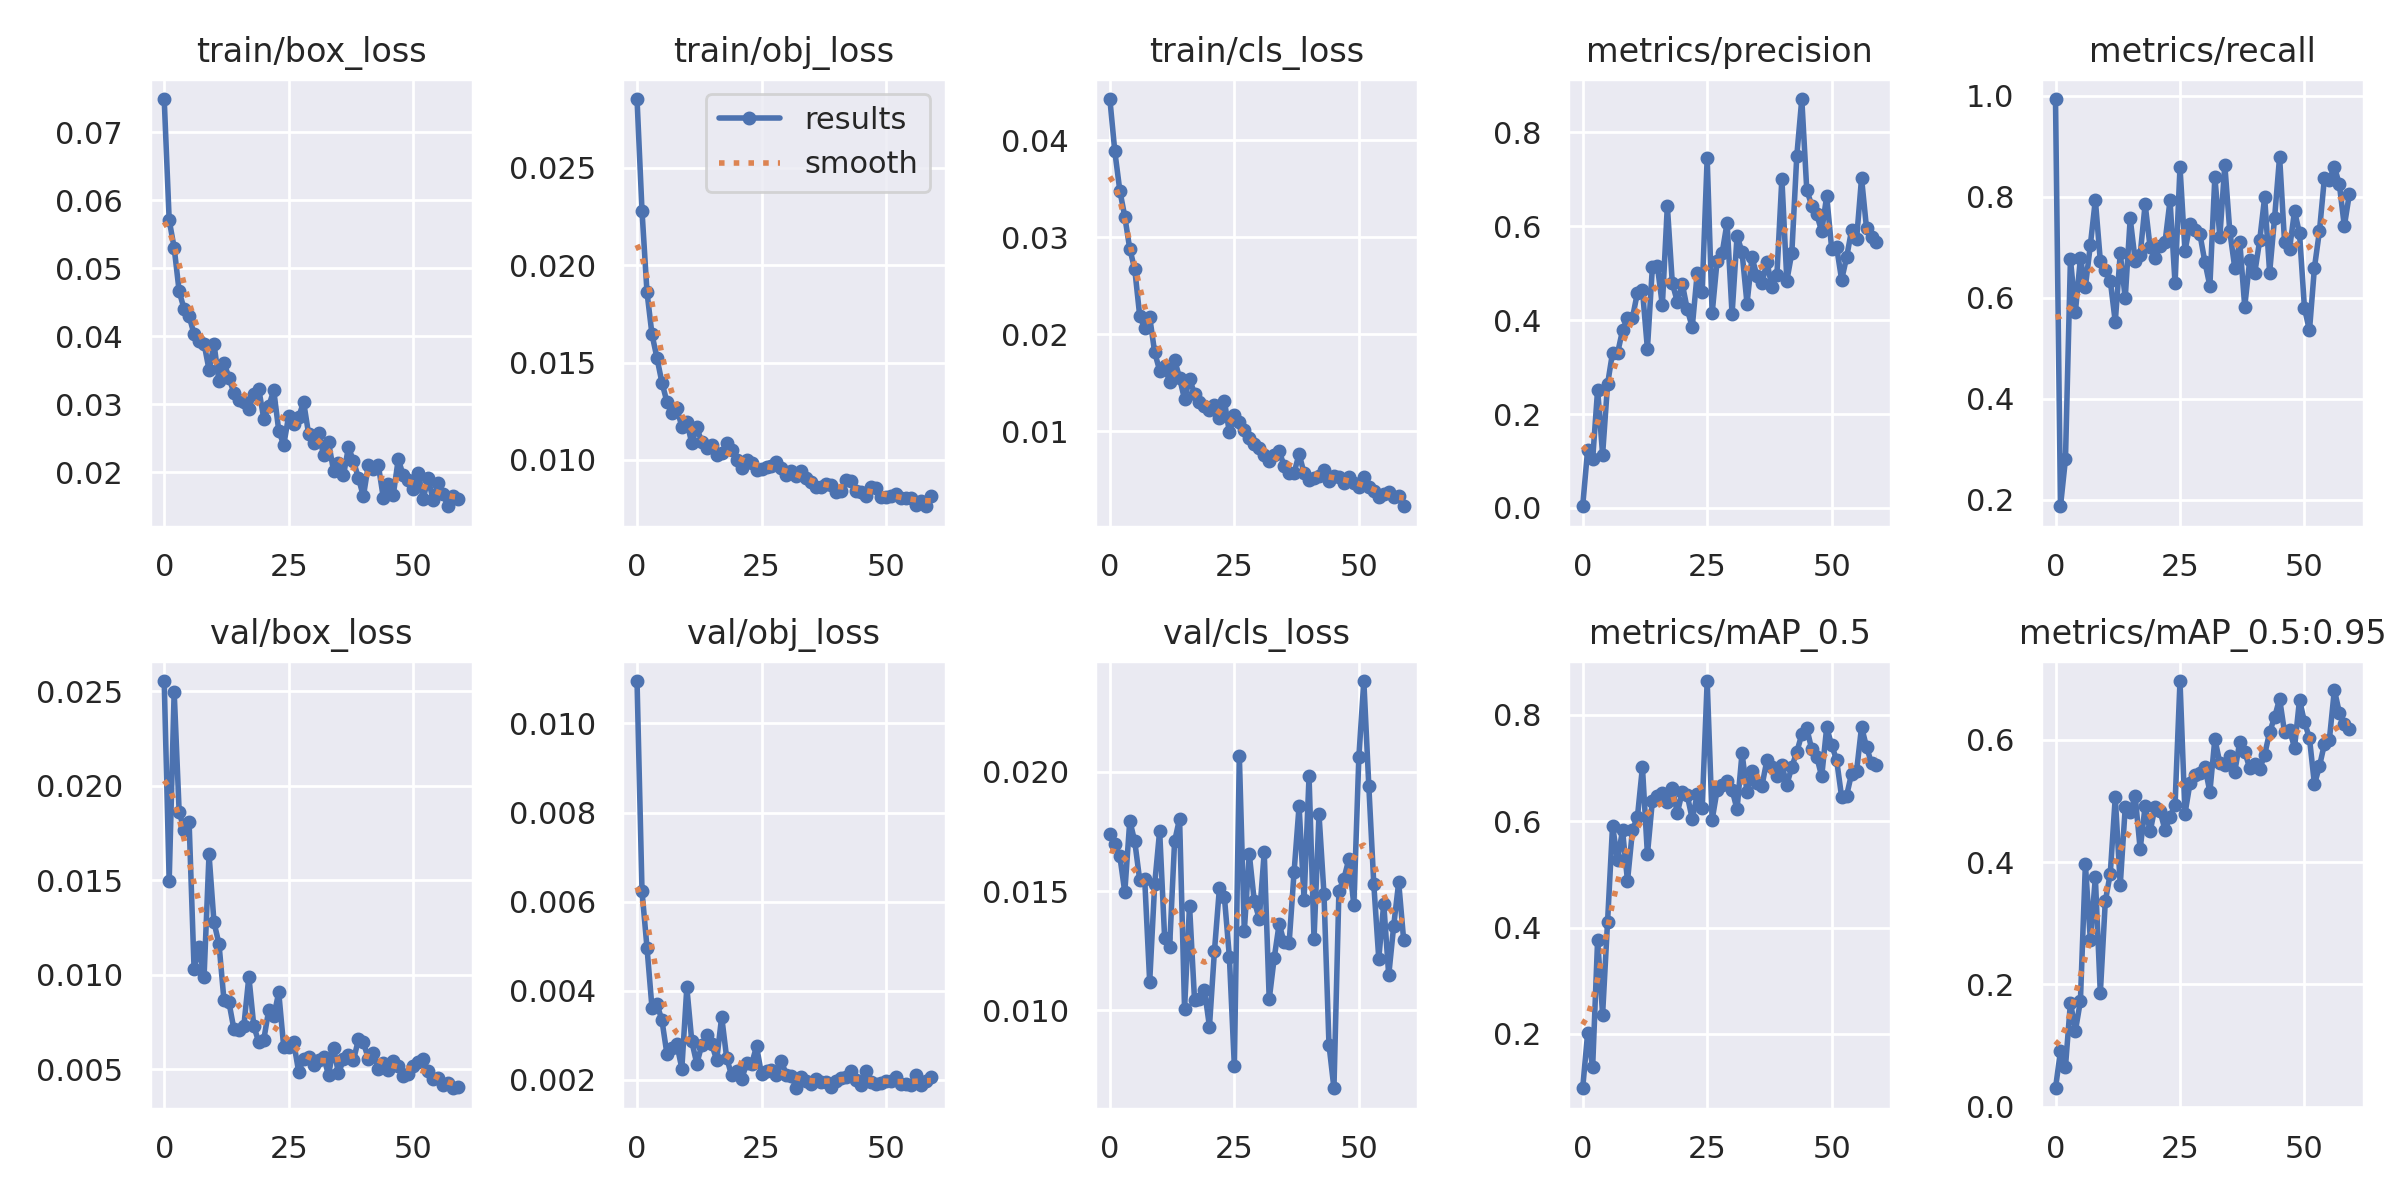

In [ ]:
from IPython.display import Image, display
import glob

# Find the latest 'results.png' file
latest_results = sorted(glob.glob('/content/yolov5/runs/train/exp/results.png'), key=len)[-1]

display(Image(filename=latest_results, width=800))


**DOWNLOADED THE MODEL FOR FURTHER PROCESSING**

**LIBRARIES REQUIRD FOR TESTING**

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path
from google.colab.patches import cv2_imshow


**LOADING THE TRAINED YOLOV5 MODEL**

In [ ]:
model_path = '/content/drive/MyDrive/INFOSYS_FILES/NEW_best.pt'
model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path, force_reload=True)


/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2024-11-13 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7026307 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


**TESTING WITH IMAGES**

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.am

Raw predictions: [[     61.669      29.452       609.9      585.11      0.6988           1]]
Raw predictions: [[     70.134      26.757      599.75      589.84     0.70851           4]]
Raw predictions: [[     47.039      23.555      603.92      744.59     0.79848           5]]
Raw predictions: [[     244.24      273.76      377.58      403.68     0.59063           2]]
Raw predictions: [[     81.471      22.665      586.73       694.3     0.62075           4]]
Raw predictions: [[     26.301           0       621.8         640     0.66031           0]]


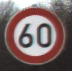

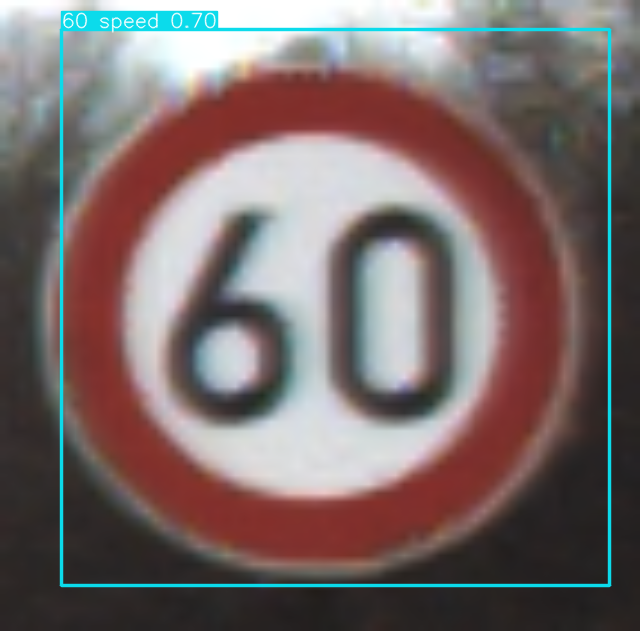

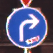

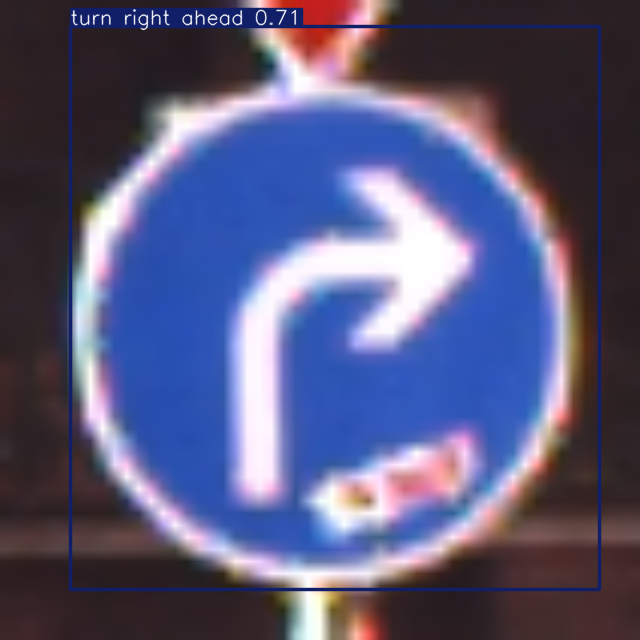

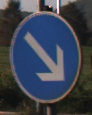

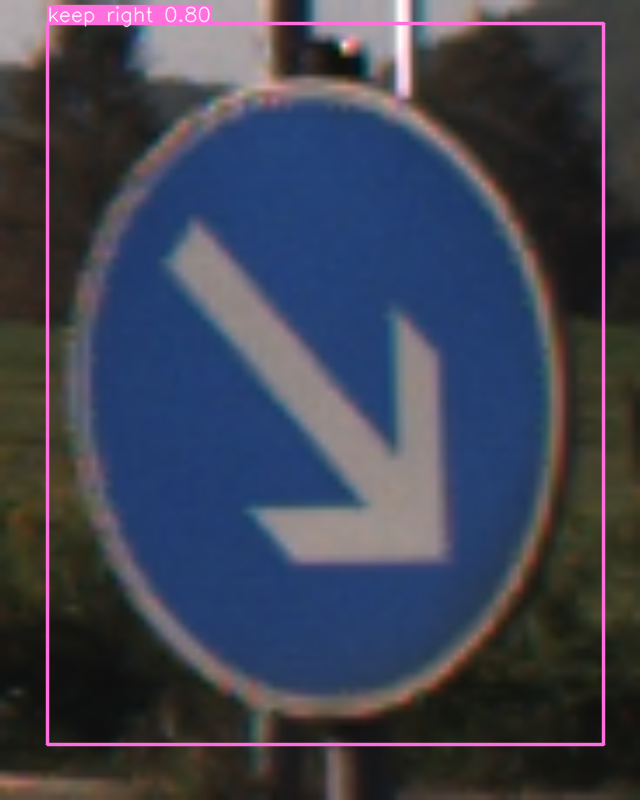

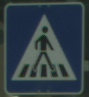

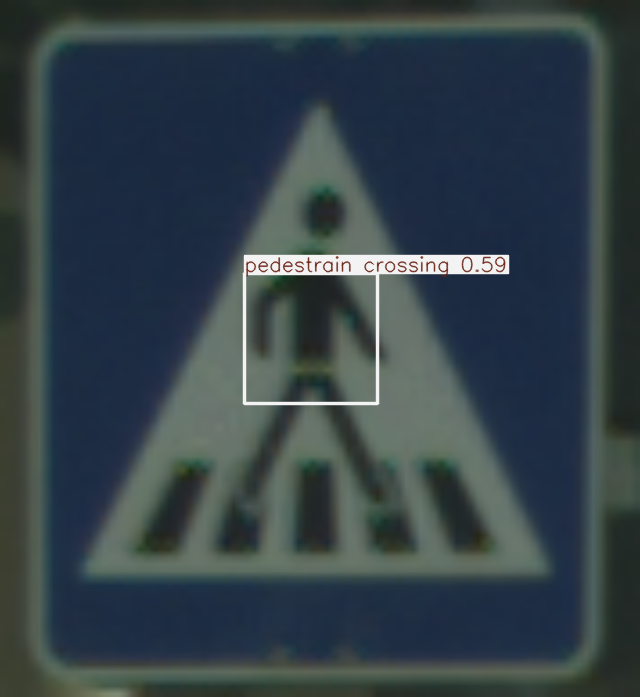

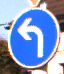

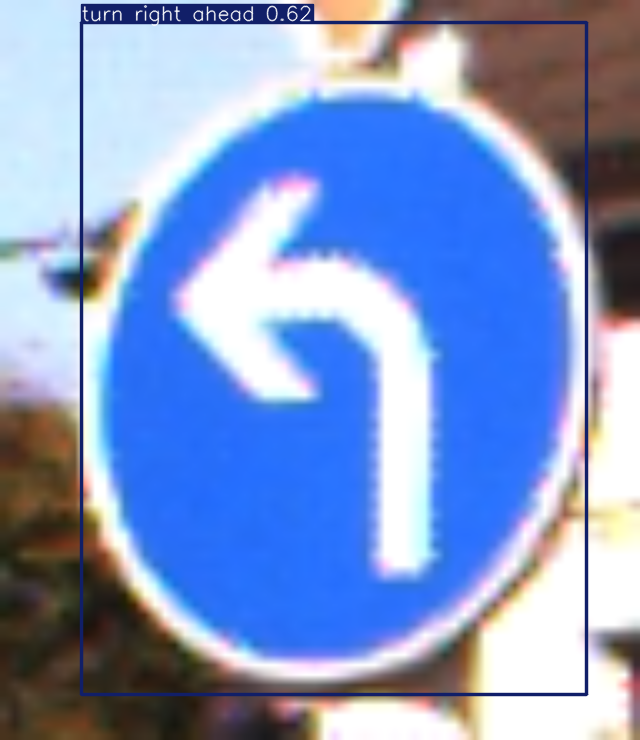

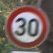

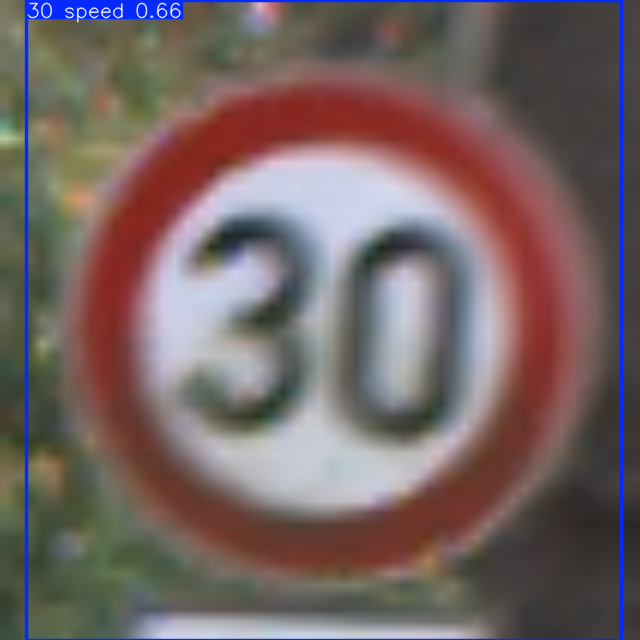

In [ ]:

image_files = ['/content/TEST_IMG1.png','/content/TEST_IMG2.png','/content/TEST_IMG3.png','/content/TEST_IMG4.png','/content/TEST_IMG5.png','/content/TEST_IMG6.png']

results_dir = '/content/yolov5/results'
os.makedirs(results_dir, exist_ok=True)

def resize_image(image, target_width=640):
    height, width = image.shape[:2]
    scale = target_width / width
    new_size = (target_width, int(height * scale))
    return cv2.resize(image, new_size)


results_data = []
for image_path in image_files:
    img = cv2.imread(str(image_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the image
    img_resized = resize_image(img_rgb, target_width=640)
    results = model(img_resized)
    # results.print()


    raw_preds = results.pred[0].cpu().numpy()
    print("Raw predictions:", raw_preds)

    result_img = results.render()[0]


    results_data.append((img_rgb, result_img, raw_preds))

    # Save the result image
    output_image_path = os.path.join(results_dir, f"{Path(image_path).stem}_result.png")
    cv2.imwrite(output_image_path, cv2.cvtColor(result_img, cv2.COLOR_RGB2BGR))

for original_img, result_img, preds in results_data:

    original_img_bgr = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR)
    cv2_imshow(original_img_bgr)
    cv2.waitKey(0)


    result_img_bgr = cv2.cvtColor(result_img, cv2.COLOR_RGB2BGR)
    cv2_imshow(result_img_bgr)
    cv2.waitKey(0)


plt.tight_layout()
